# Network of Genres

This algorithm aims to perform community detection using Louvain Modularity on different metal music subgenres, based on data obtained by web parsing from Encyclopedia Metallum. Thereafter, we can use the features extracted using dependency parsing to understand these clusters better.

In [1]:
from community import best_partition, modularity
import numpy as np
import pandas as pd
import networkx as nx
import collections as clt
import matplotlib.pyplot as plt
import pickle
import itertools
from joblib import Parallel, delayed
import math
import time

The following set of data contains both the raw data from Encyclopedia Metallum, and also processed data which includes features extracted through dependency parsing for each of the review texts. A sample of the data is shown below.

In [2]:
df = pd.read_csv('reviews_full_v10.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,...,Band_Genre,Combined_Genre,Key Features,Cleansed Features,Cleansed Text,Product Features,Product Features_dep,neg,neu,pos
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,...,groove metal|thrash metal,technical thrash metal|math metal|progressive ...,originally bought|entire album|sounded variati...,originally bought|entire album|sounded variati...,I originally bought Chaosphere in late 2000......,entire album|sounded variation|grown appreciat...,tacky place|respective instruments|vocal perfo...,0.025,0.826,0.149
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,...,grindcore|death metal,grindcore|melodic death metal,somewhat song structures|song structures|injec...,somewhat song structures|song structures|injec...,A midpoint between Carcass' early grind albums...,somewhat song structures|song structures|injec...,melodic variety|vocal performances|enjoyable a...,0.038,0.850,0.111
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,...,symphonic metal|power metal,symphonic power metal,general consensus|lose credibility|sung poet|b...,general consensus|lose credibility|sung poet|b...,"I'm not hard-core into metal at all, really, b...",general consensus|lose credibility|sung poet|b...,beautiful melody|beautiful example|general con...,0.026,0.771,0.202
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,...,thrash metal|power metal,heavy metal|us power metal,new album fact|old material|bought big fan|big...,new album fact|old material|bought big fan|big...,"This is not a new album, but in fact, five alb...",new album fact|old material|bought big fan|big...,different versions|original vocals|old materia...,0.031,0.723,0.246
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,...,speed metal|power metal,power metal,accurate description album|vocal lines|meaty a...,accurate description album|vocal lines|meaty a...,I've been trying for months to come up with an...,accurate description album|vocal lines|meaty a...,catchy songs|bad album|vocal lines|little line...,0.130,0.747,0.123


In [3]:
plt.rcParams["figure.figsize"] = (12,10) #defining size of plots

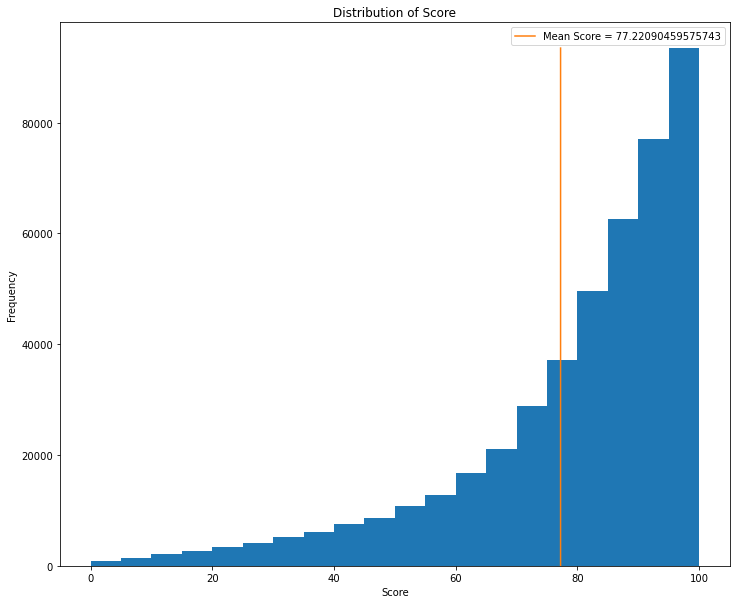

In [24]:
plt.title('Distribution of Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.hist(df['Score'], 20, cumulative = True)
plt.plot([df['Score'].mean()]*len(df), [x for x in range(len(df))], label = 'Mean Score = '+str(df['Score'].mean()))
plt.legend()
plt.savefig("Distribution of Score.png")
plt.show()

In [4]:
G = nx.Graph()
B = nx.Graph()

Firstly, a bipartite graph is constructed between genres and users, where an edge represents that a genre has been reviewed by a particular user. We also set a positive score threshold to be 75 as we define a positive review score to be more than or equal to 75.

In [5]:
#construction of bipartite graph
genres = set()
users = set()
posScore = 75
def isNaN(x):
    return x != x
for index,row in df.iterrows():
    if row['Score'] < posScore: #removing reviews with low score 
        continue
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    user = row['User']
    album = row['Release'] + 'A'
    users.add(user)
    for genre in genre_list:
        genres.add(genre)
        if B.has_edge(user,genre):
            B[user][genre]['weight'] += 1
        else:
            B.add_edge(user, genre, weight = 1)

In [6]:
B.number_of_nodes(), B.number_of_edges()

(8344, 33217)

The following set of code identifies and removes the supernodes which are structural holes. This is because of the observation that these supernodes can dilute the edges and make clustering more difficult.

[131, 125, 84, 82, 82, 81, 77, 75, 72, 72, 70, 67, 66, 64, 63, 62, 62, 61, 61, 60, 58, 55, 55, 54, 54, 54, 53, 53, 51, 51]


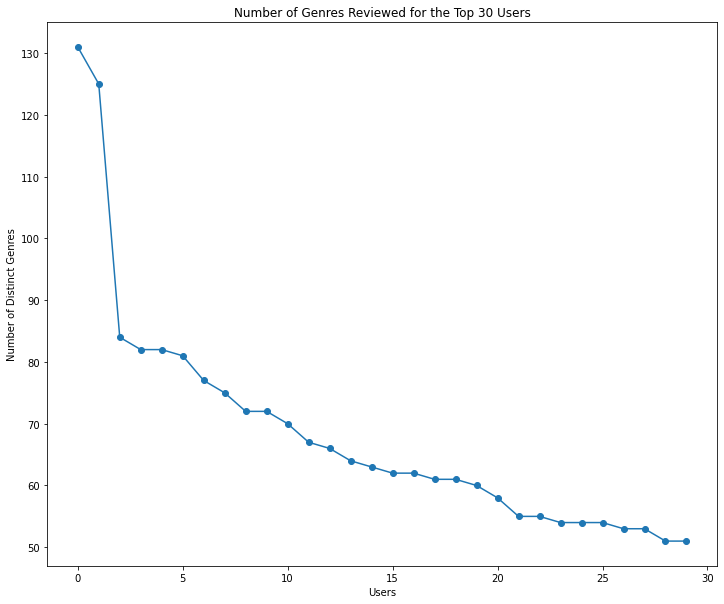

In [25]:
plt.title('Number of Genres Reviewed for the Top 30 Users')
plt.ylabel('Number of Distinct Genres')
plt.xlabel('Users')
tmp = sorted([B.degree[user] for user in users])[-30:]
tmp.reverse()
plt.plot(tmp)
plt.scatter(range(len(tmp)),tmp)
print(tmp)
plt.savefig('bipartite_degree.png')
plt.show()

In [8]:
#removing users with high degree
remove_users = set()
for user in users.copy():
    if B.degree[user] > 100:
        B.remove_node(user)
        print(user)
        remove_users.add(user)
        users.remove(user)

autothrall
hells_unicorn


Then we proceed to create the Network of Genres, where two genres share an edge if they have both been reviewed by a similar user. The edge weight is defined as the number of similar users.

In [9]:
G = nx.Graph()
for genre1 in genres:
    if genre1 not in B.nodes():
        continue
    for user in B.adj[genre1]:
        for genre2 in B.adj[user]:
            if genre2 >= genre1:
                continue
            if G.has_edge(genre1,genre2):
                G[genre1][genre2]['weight'] += 1
                
            else:
                G.add_edge(genre1, genre2, weight = 1)
                

In [10]:
G.number_of_nodes(), G.number_of_edges()

(289, 18130)

The following code cell removes manually identified non-metal genres which can be present in the data. 

In [11]:
genre_group = pickle.load(open('genre_group.p','rb'))
print(G.number_of_nodes())
G2 = G.copy()
for node in G2.nodes():
    if node not in genre_group:
        pass
    elif  genre_group[node] == 'Non-metal' or genre_group[node] == 'Others': #only consider metal genres
        G.remove_node(node)
print(G.number_of_nodes())

289
190


In [12]:
G3 = G.copy()

Thereafter, we perform the K-Core algorithm to remove unimportant genres to reduce noise in the network.

In [13]:
K = G3.copy()
K.remove_edges_from(nx.selfloop_edges(K))
K = nx.k_core(K)
sortbylen = lambda cc : len(cc)
Core = K.subgraph(sorted(list(nx.connected_components(K)), key = sortbylen)[-1])
#nx.draw(Core, node_size = 20)

In [14]:
Core.number_of_nodes(),Core.number_of_edges()

(109, 5649)

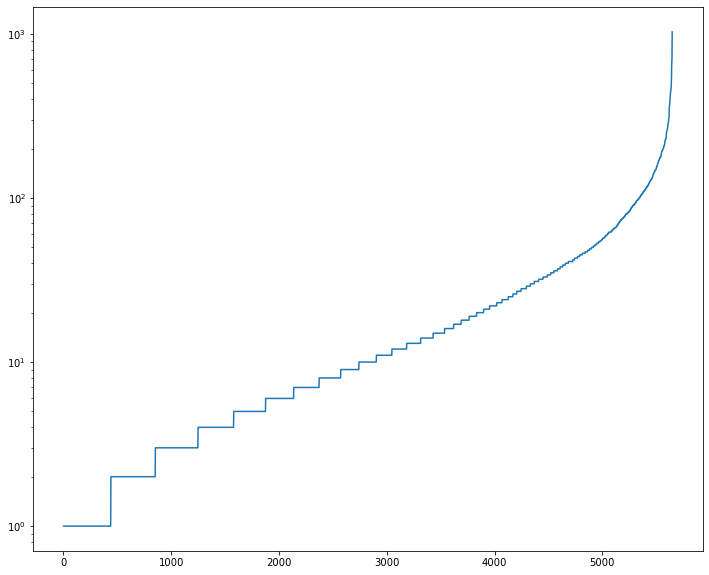

In [15]:
plt.semilogy(sorted(list(nx.get_edge_attributes(Core,'weight').values())))
plt.show()

In [16]:
genre_group = pickle.load(open('genre_group.p','rb'))
len(genre_group) #number of initial genres

298

The Louvain Method for Community Detection is not exact as exact modularity optimization would be NP-Hard. (Blondel, 2011) Hence there is a need to an average partitioning of the genres based on a probabilistic method, to obtain accurate and stable clusters. 
The network is partitioned using the Community Detection Algorithm for 100 times, which is more than sufficient to create an accurate average network of genres. This new average network of genres is created with the same nodes (i.e. genres) but the edge weights are now computed such that the weight of an edge between Genre A and Genre B is the probability that Genre A and Genre B fall in the same cluster during the 100 repeated partitioning earlier. This new Probability Network of Genres undergoes another round of 100 times of partitioning. This process repeats itself until the probabilities (edge weights) converge to 1, when maximum certainty is obtained, and the resultant average Network of Genres would be obtained, where all inter-cluster edges would be removed. 

Below shows the code to obtain average partitionings. the Joblib library is used to perform parallel computation for more efficient runtime.

In [17]:
def freq_network_parr(Graph, n_iter, n_jobs, width = 'weight', res = 1):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = width, resolution = res) for i in range(n_iter))
    
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]))
    print(nx.number_connected_components(Graph), N, len(Graph.edges()))
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v][width] += 1
                else:
                    G.add_edge(u,v)
                    G[u][v][width] = 1
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)]))
    print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

In [18]:
#H = G.copy()
H = Core.copy()
while not no_crossedges(H):
    H = freq_network_parr(H, 100, 2)

1 5886 5649
1 5886 4202
1 5886 4202
3 2372 2372


In [19]:
partitions = [cc for cc in nx.connected_components(H)]

In [20]:
def getScore(Graph):#using original graph
    comps = list(nx.connected_components(Graph))
    subgraphs = [Core.subgraph(comp) for comp in comps]
    ave_weight = [sum([Core[u][v]['weight']/sub.number_of_edges() for u,v in sub.edges()]) for sub in subgraphs]
    ave_cluster_weight = [sum([Core[u][v]['weight']/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for u,v in sub.edges()]) for sub in subgraphs]
    density = [sub.number_of_edges()/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for sub in subgraphs]
    std_dev = [np.std([Core[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    #ave_coeff = [nx.average_clustering(Core, nodes = sub.nodes(), weight = 'weight') for sub in subgraphs]
    ave_coeff = [nx.average_clustering(sub, weight = 'weight') for sub in subgraphs]
    #ave_weight1 = [np.mean([G[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    return ave_weight, ave_cluster_weight, density, std_dev, ave_coeff

In [21]:
[len(cc) for cc in partitions]

[12, 50, 47]

In [22]:
def genData(Graph, ind):
    ret = pd.DataFrame()
    ret['Genres'] = list(nx.connected_components(Graph))
    ret['Sizes'] = [len(cc) for cc in nx.connected_components(Graph)]
    ret['Average_Weight'], ret['Average_Weight_by_Nodes'], ret['Cluster_Density'], ret['Std_Dev'], ret['Average_Clustering_Coefficient'] = getScore(Graph)
    ret.to_csv('round'+str(ind)+'_genre.csv', index = False)
    return ret
data = genData(H,1)
data

,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{metalcore, black metal, progressive death met...",12,124.348485,124.348485,1.000000,166.040839,0.089823
1,"{extreme progressive metal, psychedelic doom m...",50,22.050707,21.654694,0.982041,29.144492,0.066756
2,"{extreme power metal, technical thrash metal, ...",47,22.954633,21.999075,0.958372,51.204741,0.021539


In [23]:
clusters = []
inp = input('Enter Cluster ID to Keep: ')
if inp != 'None':
    for x in inp.split():
        clusters.append(G.subgraph(list(nx.connected_components(H))[int(x)]))

Enter Cluster ID to Keep:  0


Further breakdown of large clusters:

In [24]:
from IPython.display import display, HTML
def breakDown(inds):
    for ind in inds:
        G1 = Core.subgraph(list(nx.connected_components(H))[ind])
        while not no_crossedges(G1):
            G1 = freq_network_parr(G1, 100, 2)
        print('End Clustering: ',ind)
        display(genData(G1,'2-'+ str(ind)))
        inp1 = input('Clusters to keep')
        inp2 = input('Clusters to breakdown')
        keep = {}
        brk = {}
        if inp1 != 'None':
            keep = {int(x) for x in inp1.split(' ')}
        if inp2 != 'None':
            brk = {int(x) for x in inp2.split(' ')}
        for i,comp in enumerate(nx.connected_components(G1)):
            if i in keep:
                clusters.append(Core.subgraph(comp))
            elif i in brk:
                G2 = Core.subgraph(comp)
                while not no_crossedges(G2):
                    G2 = freq_network_parr(G2, 100, 2)
                print('End Clustering: ',i)
                display(genData(G2,'3-'+ str(i)))
                for cc in nx.connected_components(G2):
                    clusters.append(Core.subgraph(cc))

In [25]:
inp = 0
tmp = []
inp = input('Enter Cluster IDs for Breakdown: ')
breakDown([int(x) for x in inp.split()])

Enter Cluster IDs for Breakdown:  1 2


1 1225 1203
1 1225 760
1 1225 760
4 398 398
End Clustering:  1


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{post-metal, atmospheric sludge metal, depress...",8,38.714286,38.714286,1.000000,30.775520,0.234558
1,"{psychedelic doom metal, stoner metal, drone d...",11,35.727273,35.727273,1.000000,55.010893,0.096545
2,"{extreme progressive metal, pagan black metal,...",25,19.789831,19.460000,0.983333,23.567499,0.105773
3,"{gothic doom metal, melodic doom metal, atmosp...",6,24.000000,24.000000,1.000000,30.086542,0.168902


Clusters to keep 0 1 3
Clusters to breakdown 2


1 300 295
1 300 229
1 300 229
3 98 98
End Clustering:  2


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{avantgarde metal, extreme progressive metal, ...",11,21.818182,21.818182,1.0,24.732085,0.149548
1,"{melodic black metal, viking black metal, blac...",8,30.107143,30.107143,1.0,29.128213,0.170319
2,"{experimental death metal, symphonic death met...",6,13.666667,13.666667,1.0,14.704497,0.173268


1 1081 1036
1 1081 637
1 1081 637
2 531 531
End Clustering:  2


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{technical thrash metal, industrial progressiv...",25,10.024735,9.456667,0.943333,12.291344,0.114847
1,"{extreme power metal, progressive metal, us po...",22,48.748899,47.904762,0.982684,94.509694,0.045995


Clusters to keep None
Clusters to breakdown 0 1


1 300 283
1 300 225
1 300 225
3 96 96
End Clustering:  0


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{new wave of british heavy metal, first wave o...",9,16.500000,16.500000,1.000000,15.217862,0.213275
1,"{melodic progressive metal, technical thrash m...",6,9.642857,9.000000,0.933333,16.038379,0.090061
2,"{neoclassical heavy metal, extreme industrial ...",10,8.418605,8.044444,0.955556,11.200566,0.118242


1 231 227
1 231 141
1 231 141
2 126 126
End Clustering:  1


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{djent, extreme power metal, progressive heavy...",15,11.683168,11.238095,0.961905,13.141221,0.143509
1,"{heavy metal, progressive metal, us power meta...",7,256.857143,256.857143,1.000000,188.379628,0.320446


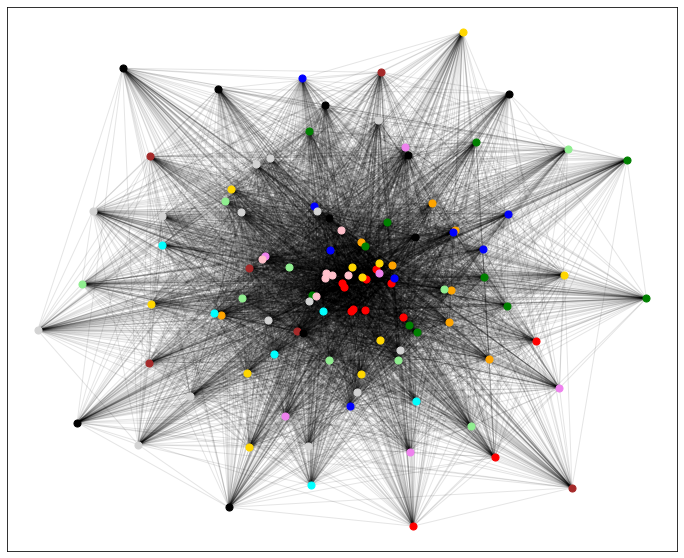

In [26]:
pos=nx.spring_layout(Core, weight = 'weight')
colors = ['red','orange','gold','green','blue','violet','cyan','lightgreen','brown','black','lightgrey','pink']
attr = {}

for i,cluster in enumerate(clusters):
    nx.draw_networkx_nodes(Core,pos,node_size = 50,
                       nodelist=list(cluster.nodes()),
                       node_color=colors[i])
    for node in cluster.nodes():
        attr[node] = {'color':colors[i]}

nx.draw_networkx_edges(Core,pos,width=1.0, 
                      edge_color='black',
                    alpha = 0.1)

plt.show()

In [27]:
for i,cluster in enumerate(clusters):
    nx.write_graphml(cluster, "Cluster "+str(i)+".graphml" )

In [28]:
#nx.write_gpickle(Core,'network_genres.p')

In [29]:
cluster_id = {}
for i,cluster in enumerate(clusters):
    for genre in cluster.nodes():
        cluster_id[genre] = i

In [30]:
nx.set_node_attributes(Core, attr)
Core1 = Core.copy()

all_edges = sorted([(Core[u][v]['weight'],u,v) for u,v in Core.edges()], reverse = True)

tmp = [3 for x in clusters]
to_keep = set()
cnt = 0

for w,u,v in all_edges:
    if cluster_id[u] != cluster_id[v] and (tmp[cluster_id[u]] > 0 or tmp[cluster_id[v]] > 0):
        tmp[cluster_id[u]] -= 1
        tmp[cluster_id[v]] -= 1
        to_keep.add((u,v))
    if cluster_id[u] != cluster_id[v]:
        cnt += 1

for u,v in Core.edges():
    if (u,v) not in to_keep and cluster_id[u] != cluster_id[v]:
        Core1.remove_edge(u,v)

nx.write_graphml(Core1, "Core.graphml" )
print(cnt, Core.number_of_edges(), Core1.number_of_edges(), len(to_keep))

5172 5649 510 33


In [31]:
out_edges = [0 for x in clusters]
for u,v in Core.edges():
    if cluster_id[u] != cluster_id[v]:
        out_edges[cluster_id[u]] += Core[u][v]['weight']
        out_edges[cluster_id[v]] += Core[u][v]['weight']

The following code uses the extracted features from each of the review texts using dependency parsing and TF-IDF as illustrated in our paper, to identify the most meaningful features for each genre cluster.

In [32]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer() 
def isNaN(x):
    return x != x

def lem(x):
    return ' '.join([lemma.lemmatize(word) for word in x.split()])

In [33]:
t1 = time.time()
all_features = [{} for i in range(len(clusters))]

for i,row in df.iterrows():
    if isNaN(row['Combined_Genre']) or isNaN(row['Product Features_dep']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    if i%5000 == 0:
        print(i,time.time()-t1)
    feature_list = [lem(feature) for feature in row['Product Features_dep'].split('|') if 'metal' not in feature] #so genre names are not included
    cluster_ids = set([cluster_id[genre] for genre in genre_list if genre in cluster_id])
    for clus in cluster_ids:
        for phrase in feature_list:
            if phrase in all_features[clus]:
                all_features[clus][phrase] += 1
            else:
                all_features[clus][phrase] = 1

0 0.20245814323425293
5000 3.9223721027374268
20000 8.837264776229858
25000 10.297332286834717
30000 11.74446439743042
35000 13.317259550094604
40000 15.026724815368652
45000 16.691240787506104
50000 18.36180591583252
55000 20.018345594406128
60000 21.72186517715454
65000 23.48615050315857
70000 25.259409189224243
75000 27.344139099121094
85000 31.418249368667603


In [34]:
import pickle

pickle.dump(all_features,open('all_features_by_cluster.p','wb'))

0 0.20545101165771484
10000 4.739330291748047
20000 9.933446884155273
30000 12.289147853851318
40000 15.132548332214355
50000 17.468303442001343
60000 19.81203818321228
70000 22.823989391326904
80000 25.68836808204651
90000 28.329306840896606


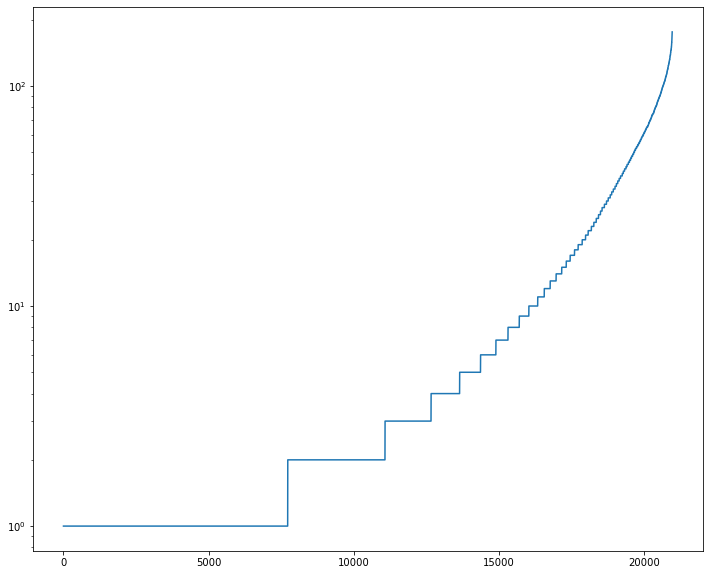

In [35]:
def isNaN(x):
    return x != x

adj_to_genre = {}
t1 = time.time()
all_genres = set()
for i,row in df.iterrows():
    if i%10000 == 0:
        print(i,time.time()-t1)
    if isNaN(row['Product Features_dep']) or isNaN(row['Combined_Genre']):
        continue
    features = row['Product Features_dep'].split('|')
    genres = row['Combined_Genre'].split('|')
    album = row['Release']
    for genre in genres.copy():
        if genre not in genre_group or genre_group[genre] == 'Non-metal' or genre_group[genre] == 'Others':
            genres.remove(genre)
    
    for feature in features:
        adj = lemma.lemmatize(feature.split(' ')[0])
        if adj not in adj_to_genre:
            adj_to_genre[adj] = set()
        for genre in genres:
            adj_to_genre[adj].add(genre)
            all_genres.add(genre)

genfreq = {}
for adj in adj_to_genre:
    if len(adj_to_genre[adj]) != 0:
        genfreq[adj] = len(adj_to_genre[adj])

plt.semilogy(sorted(genfreq.values()))
plt.show()    

In [36]:
#cxt is term frequency (tf)
idf = {}
for adj in genfreq:
    idf[adj] = math.log(len(all_genres)/genfreq[adj])

tfidf_list = []

for i, tf in enumerate(all_features):
    tfidf = {}
    for feature in tf:
        adj = feature.split(' ')[0]
        tfidf[feature] = tf[feature]*idf[adj]
    tfidf_list.append(tfidf)

### Plotting of Results

Top 50 features for each cluster


124.34848484848484
['metalcore', 'death metal', 'grindcore', 'progressive death metal', 'black metal', 'progressive deathcore', 'brutal death metal', 'industrial grindcore', 'technical deathcore', 'technical death metal', 'melodic death metal', 'deathcore']
['double bass', 'old school', 'swedish band', 'clean vocal', 'previous album', 'guttural vocal', 'harsh vocal', 'rhythm guitar', 'entire album', 'acoustic guitar', 'sound quality', '21st century', 'low end', 'female vocal', 'little bit', 'catchy riff', 'norwegian band', 'subject matter', 'lyrical theme', 'bad thing', 'long time', 'french band', 'lead guitar', 'final track', 'serial killer', 'young band', 'brutal band', 'finnish band', 'main riff', 'guttural growl', 'norwegian scene', 'black band', 'fast riff', 'lyrical content', 'polish band', 'late 80', 'best song', 'sub genre', 'early 90', 'favorite track', 'raw sound', 'past year', 'american band', 'spoken word', 'favorite song', 'deep growl', '

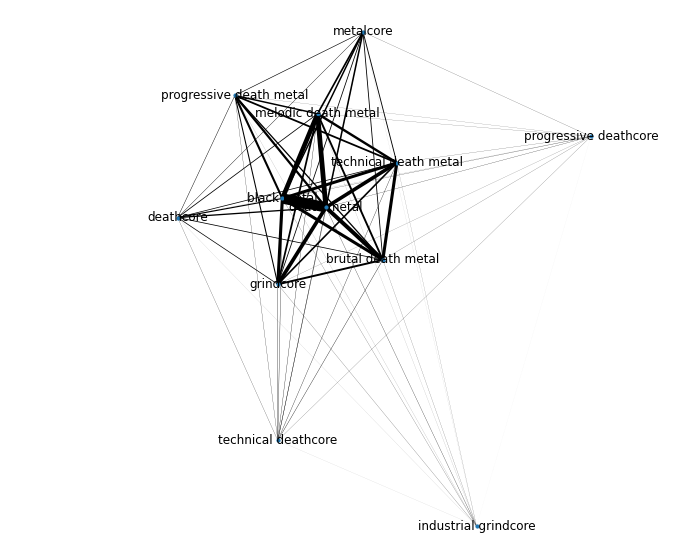


38.714285714285715
['post-metal', 'atmospheric sludge metal', 'depressive black metal', 'neofolk', 'experimental black metal', 'shoegaze', 'atmospheric black metal', 'ambient black metal']
['acoustic guitar', 'female vocal', 'clean vocal', 'depressive band', 'harsh vocal', 'distorted guitar', 'electric guitar', 'previous album', 'spoken word', 'ambient music', 'rock influence', 'sub genre', 'ambient track', 'double bass', 'final track', 'subject matter', 'sole member', 'black band', 'entire album', 'neo folk', 'favorite track', 'tortured vocal', 'urban blue', 'american band', 'lead guitar', 'cascadian scene', 'rock band', 'split album', 'bad thing', 'black album', 'long time', 'acoustic passage', 'ambient piece', 'cold atmosphere', 'ambient section', 'clean guitar', 'rock element', 'lyrical theme', 'bleak atmosphere', 'previous release', 'sound quality', 'long song', 'little bit', 'depressive atmosphere', 'depressive album', 'programmed drum', 'past year', 'overall sound', 'best song'

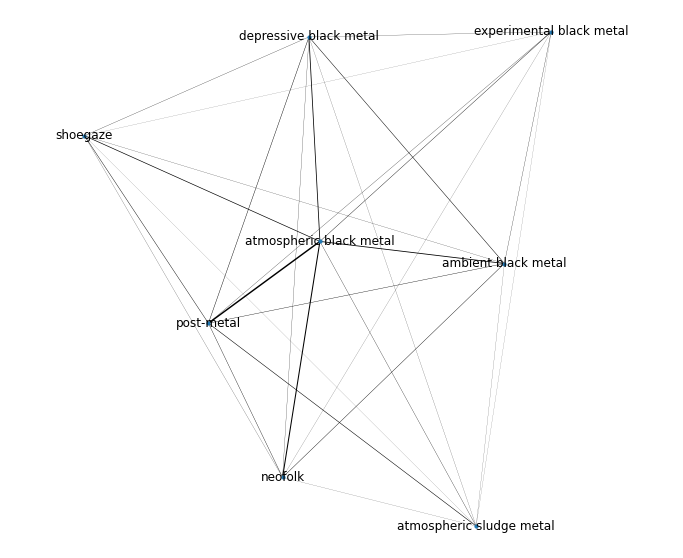


35.72727272727273
['psychedelic doom metal', 'stoner metal', 'drone doom metal', 'sludge metal', 'funeral doom metal', 'ambient doom metal', 'blackened sludge metal', 'stoner rock', 'blackened doom metal', 'psychedelic stoner metal', 'doom metal']
['funeral doom', 'female vocal', 'funeral band', 'clean vocal', 'acoustic guitar', 'lead guitar', 'serial killer', 'distorted guitar', 'harsh vocal', 'wounded king', 'subject matter', 'main riff', 'slow riff', 'long time', 'low end', 'heavy riff', 'previous album', 'little bit', 'rhythm guitar', 'sub genre', 'lyrical theme', 'entire album', 'final track', 'southern rock', 'rhythm section', 'sludgy riff', 'favorite track', 'sabbathian riff', 'double bass', 'bad thing', 'best song', 'hard rock', 'long song', 'second track', 'psychedelic rock', 'shorter song', 'old school', 'focal point', 'fuzzy guitar', 'funeral album', 'guttural vocal', 'lyrical content', 'spoken word', 'traditional doom', 'tortured scream', 'overall sound', 'second album', '

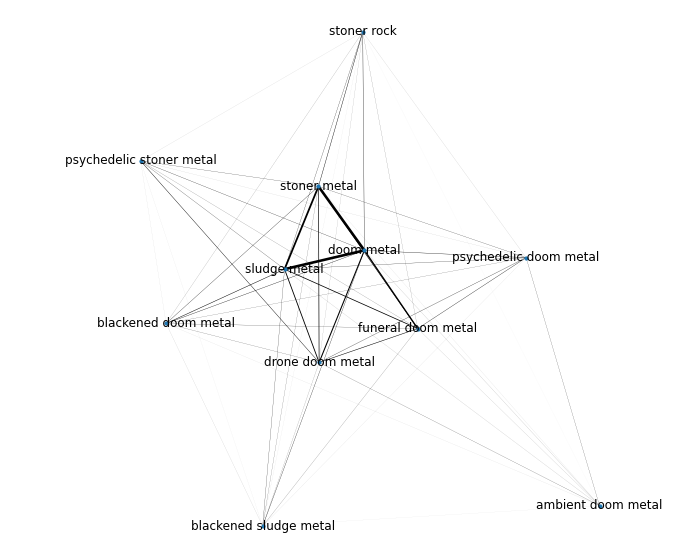


21.818181818181817
['avantgarde metal', 'extreme progressive metal', 'gothic rock', 'gothic metal', 'avantgarde black metal', 'extreme avantgarde metal', 'industrial black metal', 'progressive black metal', 'psychedelic black metal', 'instrumental post-metal', 'symphonic black metal']
['female vocal', 'clean vocal', 'avant garde', 'harsh vocal', 'gothic band', 'male vocal', 'operatic vocal', 'acoustic guitar', 'previous album', 'double bass', 'female vocalist', 'spoken word', 'norwegian band', 'symphonic band', 'electric guitar', 'entire album', 'sound effect', 'symphonic element', 'long time', 'favorite track', 'later album', 'favorite song', 'best song', 'little bit', 'norwegian scene', 'classical music', 'bad thing', 'final track', 'lyrical theme', 'best album', 'lead guitar', '21st century', 'catchy riff', 'earlier work', 'italian band', 'distorted guitar', 'latest album', 'epitome viii', 'later work', 'lyrical content', 'tyrant demo', 'earlier album', 'rhythm section', 'black ban

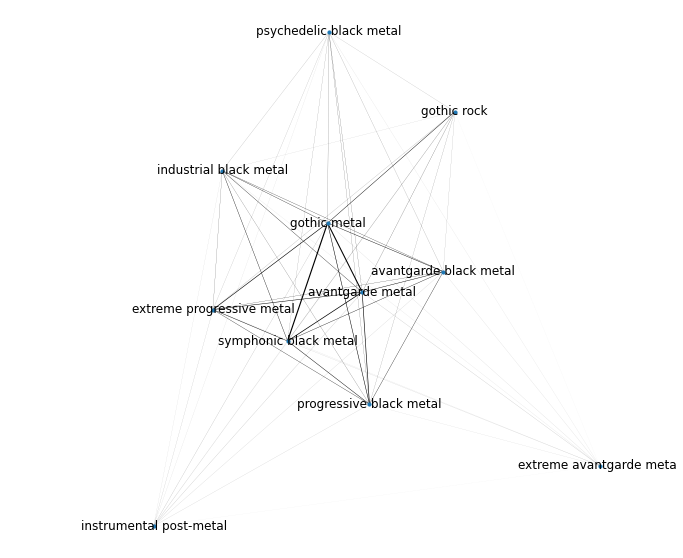


30.107142857142858
['melodic black metal', 'viking black metal', 'blackened heavy metal', 'viking folk metal', 'pagan black metal', 'celtic folk metal', 'folk metal', 'pagan folk metal']
['acoustic guitar', 'harsh vocal', 'female vocal', 'clean vocal', 'norse mythology', 'electric guitar', 'male vocal', 'double bass', 'previous album', 'pagan band', 'norwegian band', 'celtic music', 'entire album', 'best song', 'celtic folk', 'little bit', 'subject matter', 'folkish melody', 'bad thing', 'finnish band', 'lyrical theme', 'rhythm guitar', 'swedish band', 'female vocalist', 'long time', 'favorite song', 'traditional instrument', 'norwegian scene', 'native tongue', 'distorted guitar', 'acoustic passage', 'epic song', 'lead guitar', 'faroese lyric', 'best album', 'young band', 'growled vocal', 'german band', 'final track', 'lyrical content', 'celtic melody', 'celtic influence', 'catchy riff', 'native language', 'previous release', 'instrumental track', 'sound quality', 'black band', 'sub g

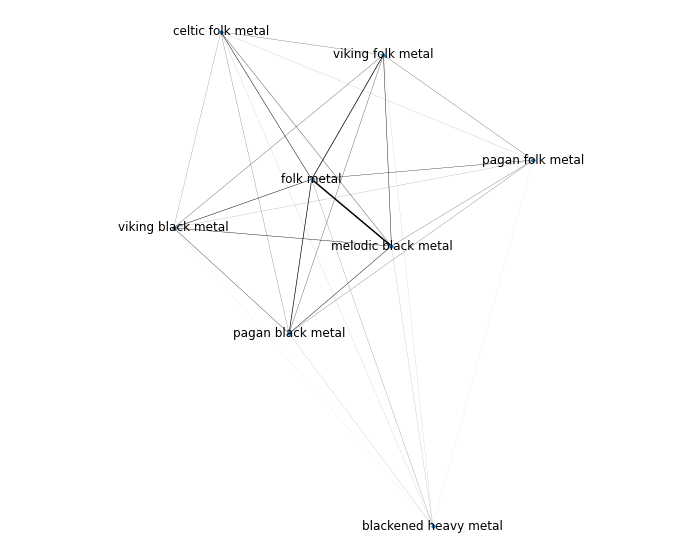


13.666666666666666
['atmospheric death metal', 'blackened thrash metal', 'symphonic death metal', 'blackened death metal', 'industrial death metal', 'experimental death metal']
['double bass', 'black death', 'canadian band', 'behemoth fan', 'female vocal', 'old school', 'previous album', '21st century', 'black thrash', 'clean vocal', 'harsh vocal', 'entire album', 'teutonic thrash', 'thrash riff', 'little bit', 'guttural vocal', 'portal album', 'long time', 'main riff', 'hyrdocianic darkness', 'lovecraftian theme', 'final track', 'polish band', 'rehearsal room', 'young band', 'deep growl', 'far cry', 'subject matter', 'memorable riff', 'bad thing', 'acoustic guitar', 'prime example', 'low end', 'nocturnus member', 'supplant god', 'brutal band', 'dark atmosphere', 'favorite song', 'lyrical content', 'italian band', 'humble opinion', 'previous release', 'storming evil', 'favourite track', 'rhythm guitar', 'longest track', 'earlier album', 'brute force', 'best album', 'extreme band']


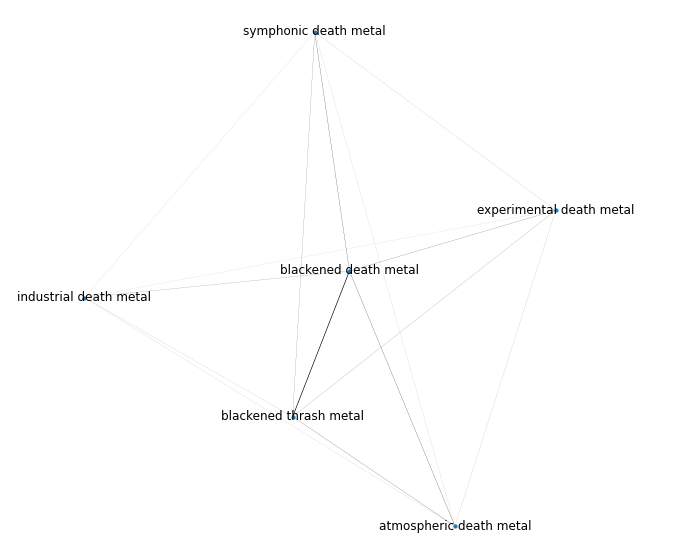


24.0
['gothic doom metal', 'melodic doom metal', 'atmospheric gothic metal', 'atmospheric doom metal', 'folk doom metal', 'death doom metal']
['female vocal', 'clean vocal', 'discouraged one', 'funeral doom', 'chompy riff', 'harsh vocal', 'southeastern scene', 'male vocal', 'acoustic guitar', 'sassy attitude', 'flippy percussion', 'growled vocal', 'gothic band', 'spoken word', 'spiffy logo', 'finnish band', 'gothic doom', 'female vocalist', 'transylvanian forest', 'lead guitar', 'deep growl', 'previous album', 'rhythm guitar', 'slow riff', 'double bass', 'old school', 'best song', 'ragged vocal', 'guttural vocal', 'distorted guitar', 'swedish band', 'gloomy atmosphere', 'prophetic throne', 'heavy riff', 'entire album', 'enforced melody', 'genital masturbation', 'longer song', 'sunny day', 'angelic voice', 'stark contrast', 'main riff', 'clean guitar', 'electric guitar', 'spoken vocal', 'dutch band', 'deathless king', 'young band', 'draconian album', 'bad thing']


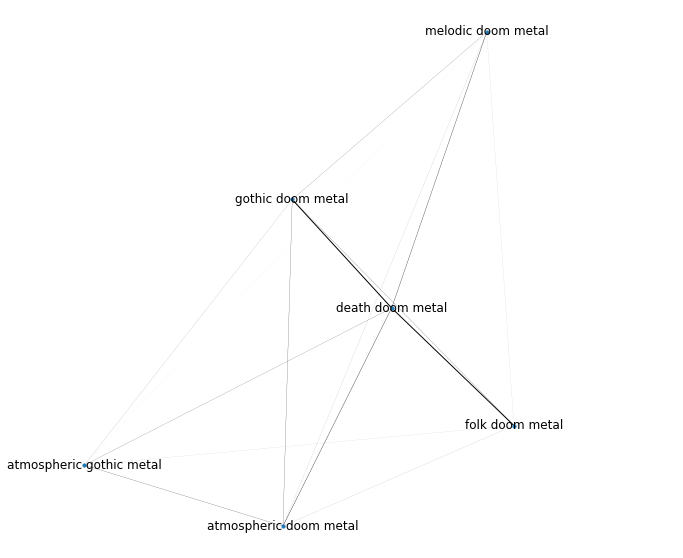


16.5
['new wave of british heavy metal', 'first wave of black metal', 'melodic thrash metal', 'bay area thrash metal', 'teutonic thrash metal', 'neoclassical power metal', 'electro industrial metal', 'crossover thrash metal', 'us industrial metal']
['main riff', 'previous album', 'live album', 'best song', '21st century', 'thrash album', 'subject matter', 'dissatisfied existence', 'double bass', 'hard rock', 'best album', 'fastest song', 'middle section', 'catchy chorus', 'rhythm guitar', 'pain album', 'old school', 'catchy riff', 'fast riff', 'late 80', 'lead guitar', 'thrash riff', 'german band', 'personal favorite', 'lyrical content', 'entire album', 'little bit', 'skip button', 'greatest album', 'thrash fan', 'thrash scene', 'classic album', 'humble opinion', 'longest song', 'teutonic thrash', 'awesome riff', 'fast song', 'acoustic guitar', 'sound quality', 'vocal performance', 'thrash band', 'bad thing', 'instant classic', 'later album', 'german thrash', 'mosh pit', 'paced riff',

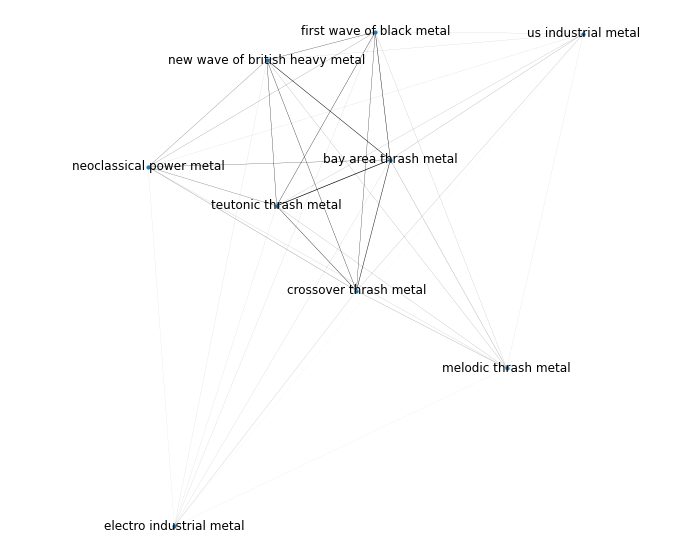


9.642857142857142
['melodic progressive metal', 'technical thrash metal', 'progressive stoner metal', 'oriental folk metal', 'progressive thrash metal', 'progressive sludge metal']
['overactive imagination', 'meshuggah fan', 'late 80', 'previous album', 'clean vocal', 'pendulous skin', 'technical thrash', 'meshuggah album', 'stall speed', 'double bass', 'entire album', 'rhythm section', 'tech thrash', 'classical music', 'progressive thrash', 'best song', 'best album', 'outer isolation', 'fast riff', 'live album', 'flatline drivel', 'underrated band', 'thrash riff', 'odd time', '21st century', 'later album', 'progressive band', 'favorite song', 'fourth album', 'progressive element', 'middle section', 'favorite track', 'favorite album', 'vehicular homicide', 'hairier personality', 'main riff', 'longer song', 'young band', 'waltari album', 'untrained ear', 'female vocal', 'copious amount', 'secret face', 'lead guitar', 'later work', 'american band', 'thrash band', 'progressive album', 's

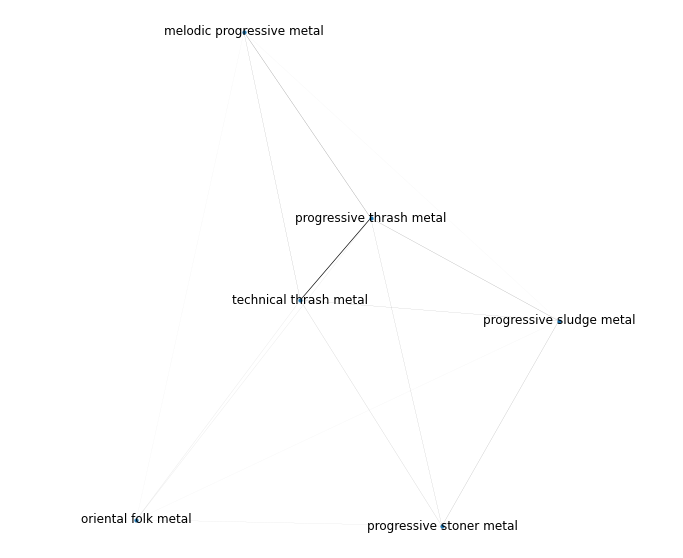


8.418604651162791
['neoclassical heavy metal', 'extreme industrial metal', 'industrial progressive metal', 'groove metal', 'progressive folk metal', 'groove thrash metal', 'industrial metal', 'industrial thrash metal', 'progressive rock', 'alternative thrash metal']
['previous album', 'tough guy', 'clean vocal', 'double bass', 'hard rock', 'main riff', 'best song', 'electric guitar', 'entire album', 'harsh vocal', 'live album', 'acoustic guitar', 'rhythm section', 'progressive rock', 'skip button', 'favorite song', 'best album', 'female vocal', 'bad thing', 'long time', 'lyrical theme', 'industrial music', 'little bit', 'open mind', 'industrial element', 'groovy riff', 'prog rock', 'progressive music', 'mixed bag', 'new album', '11th hour', '21st century', 'half thrash', 'earlier work', 'thrash riff', 'later album', 'heavy riff', 'worst song', 'focal point', 'rhythm guitar', 'served cold', 'past year', 'good song', 'previous release', 'shorter song', 'decent song', 'catchy riff', 'wor

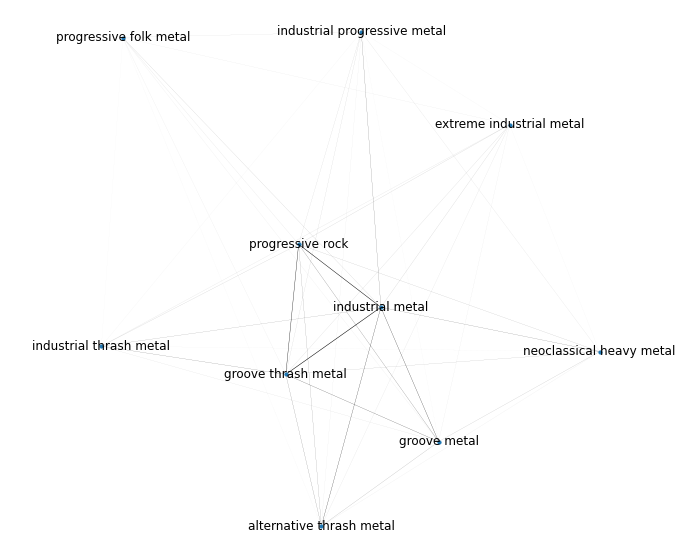


11.683168316831683
['extreme folk metal', 'djent', 'extreme power metal', 'progressive heavy metal', 'gothenburg metal', 'gothic black metal', 'progressive power metal', 'progressive math metal', 'symphonic gothic metal', 'melodic power metal', 'symphonic metal', 'progressive metalcore', 'melodic metalcore', 'symphonic progressive metal', 'extreme gothic metal']
['female vocal', 'harsh vocal', 'clean vocal', 'previous album', 'double bass', 'male vocal', 'operatic vocal', 'symphonic band', 'female vocalist', 'symphonic element', 'entire album', 'best song', 'rhythm guitar', 'acoustic guitar', 'gothic band', 'little bit', 'rhythm section', 'bad thing', 'finnish band', 'classical music', 'favorite song', 'catchy chorus', 'nightwish fan', 'subject matter', 'hard rock', 'best album', 'favorite track', 'long time', 'female singer', 'new album', '13th floor', 'latest album', 'dutch band', 'past year', 'favorite album', 'catchy riff', 'nightwish album', 'lyrical theme', 'single song', 'main 

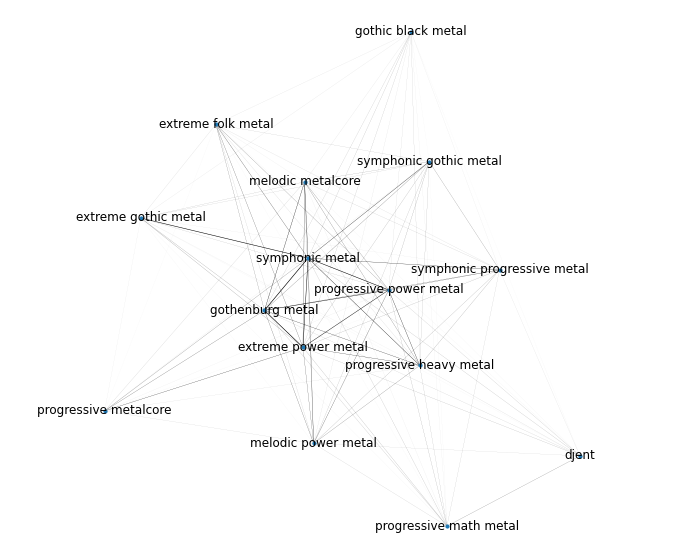


256.85714285714283
['heavy metal', 'progressive metal', 'us power metal', 'symphonic power metal', 'power metal', 'thrash metal', 'epic doom metal']
['previous album', 'hard rock', 'double bass', 'late 80', 'best song', 'main riff', 'old school', 'subject matter', 'live album', 'little bit', 'catchy chorus', 'entire album', '21st century', 'acoustic guitar', 'rhythm section', 'rhythm guitar', 'favorite song', 'blind guardian', 'catchy riff', 'female vocal', 'german band', 'vocal performance', 'long time', 'best album', 'bad thing', 'lyrical theme', 'fast song', 'young band', 'past year', 'fastest song', 'lyrical content', 'lead guitar', 'harsh vocal', 'high note', 'late 90', 'heavy riff', 'fast riff', 'favorite track', 'vocal line', 'bad song', 'clean vocal', 'final track', 'new album', 'sound quality', 'progressive band', 'solid album', 'second album', 'thrash riff', 'middle section', 'favourite song']


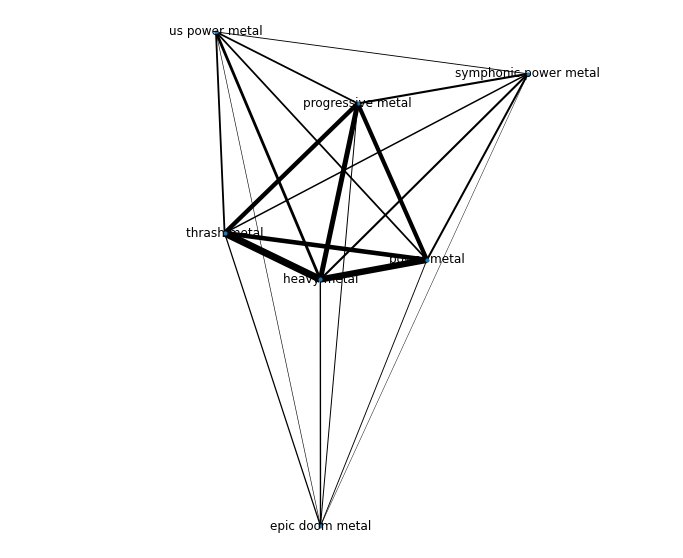

In [37]:
data = pd.DataFrame()
clus_features = []
clus_nodes = []
print('Top 50 features for each cluster\n\n')
for i,cluster in enumerate(clusters):
    pos = nx.spring_layout(cluster)
    l,r = plt.xlim()
    nx.draw(cluster, node_size = 10, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])*0.01)
    print(np.mean(np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])))
    mp = {k: v for k, v in sorted(tfidf_list[i].items(), key=lambda item: item[1], reverse = True)}
    print(cluster.nodes())
    print(list(mp.keys())[:50])
    clus_nodes.append(','.join(cluster.nodes()))
    clus_features.append(','.join(list(mp.keys())[:50]))
    plt.xlim(-1.3,1.3)
    plt.savefig('Cluster ' + str(i) +'.png')
    plt.show()
    print()


data['Genres'] = clus_nodes
data['Features'] = clus_features
data['Cluster Size'] = [cluster.number_of_nodes() for cluster in clusters]
data['% of inter-cluster edges'] = [(out_edges[i]/(sum(nx.get_edge_attributes(cluster,'weight').values()) + out_edges[i]))*100 for i,cluster in enumerate(clusters)]
data.to_csv('genre_network_results_v3.csv')